# Lecture 18: Failures in data privacy


## Learning objectives

By the end of this lecture, students should be able to:
- Understand why encrypted data might not be as private as we thought
- Understand how anonymized data can be reverse-engineered
- Understand how models can be inverted to extract input data



## Slides


<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vTWBytXWPY5uDimhERKofX_aU3RFnSvNcp5Cv7P9i-yK166mEAwYiIrj-k-u8GiQIqvR-htNYTcezbe/embed?start=false&loop=false&delayms=60000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>


```{note}
Download a PDF version [here](https://docs.google.com/presentation/d/1ZN2qiBVRZDb6FQ5y8tL62fjfns8cavUjsme9UkbGLIM/export/pdf)
```

## Example of model inversion in neural network using MNIST data

In [3]:
# !pip install torch torchvision torchaudio

First, we train a NN with two parts to simulate the Split Neural Networks (SplitNN), which is a training paradigm in which part of a network is hosted on a data holder’s device and the second part of the network is hosted on another device. 

In [5]:
from torch import nn, optim

class SplitNN(nn.Module):
    def __init__(self):
        super(SplitNN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Linear(784, 500),
            nn.ReLU(),
        )
        self.second_part = nn.Sequential(
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        return self.second_part(self.first_part(x))

target_model = SplitNN()

Let’s assume the target model has been trained on the MNIST dataset and that we can access the size 500 vector output from the **model’s first_part**


In [9]:

class Attacker(nn.Module):
    def __init__(self):
        super(Attacker, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
        )

    def forward(self, x):
        return self.layers(x)

Create data loader

In [11]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for the EMNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the EMNIST dataset
emnist_train = datasets.EMNIST(root='data', split='balanced', train=True, download=True, transform=transform)
emnist_train_loader = DataLoader(emnist_train, batch_size=64, shuffle=True)


100%|██████████| 562M/562M [00:20<00:00, 27.6MB/s] 


Extracting data/EMNIST/raw/gzip.zip to data/EMNIST/raw


In [18]:
# Load the MNIST dataset
mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)

mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)


Perhaps we don’t know exactly what data the target model has been trained on, but we do know that it’s some sort of handwritten images. 

Therefore we can use part of the EMNIST dataset of handwritten letters to train our attacker.


In [13]:
# Initialize the attacker model and optimizer
attacker = Attacker()
optimiser = optim.Adam(attacker.parameters(), lr=1e-4)

# Training loop
for data, targets in emnist_train_loader:
    # Flatten the input data
    data = data.view(data.size(0), -1)
    
    # Reset gradients
    optimiser.zero_grad()

    # First, get outputs from the target model
    target_outputs = target_model.first_part(data)

    # Next, recreate the data with the attacker
    attack_outputs = attacker(target_outputs)

    # We want attack outputs to resemble the original data
    loss = ((data - attack_outputs) ** 2).mean()

    # Update the attack model
    loss.backward()
    optimiser.step()

Let's plot our original data against the recreated data

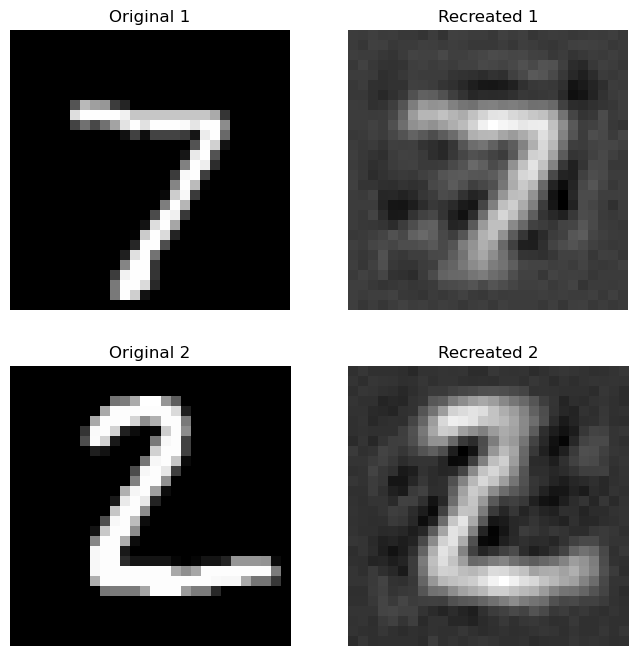

In [22]:
import matplotlib.pyplot as plt
# Testing loop
for data, targets in mnist_test_loader:
    # Flatten the input data
    data = data.view(data.size(0), -1)

    # Get outputs from the target model
    target_outputs = target_model.first_part(data)

    # Recreate the data with the attacker
    recreated_data = attacker(target_outputs)

    # Plot the first 2 original and recreated images for comparison
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    for i in range(2):
        # Original image
        axes[i, 0].imshow(data[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
        axes[i, 0].set_title(f"Original {i+1}")
        axes[i, 0].axis('off')

        # Recreated image
        axes[i, 1].imshow(recreated_data[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
        axes[i, 1].set_title(f"Recreated {i+1}")
        axes[i, 1].axis('off')

    plt.show()
    break  # Only plot for the first batch